### Finding the best business to start in Kampala using Foursquare Data

Using the data from foursqaure, I want to find the most common places in Kampala with some types of businesses and dentify their characteristics

In [1]:
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import seaborn as sns

print('Libraries imported.')


Libraries imported.


In [35]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = ''

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


## Doing reserach about Kampala
    - I want to find out the known businesses in Kampala and how they are staked against each other from Foursquare

### Get coordinates of Kampala

In [3]:
def geo_coordinates(borough):
    address = borough
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    return {'latitude':location.latitude, 'longitude': location.longitude}


In [4]:
neighborhood_name = 'kampala'

In [5]:
neighborhood_longitude = geo_coordinates(neighborhood_name)['longitude']
neighborhood_latitude= geo_coordinates(neighborhood_name)['latitude']


In [6]:
# type your answer here
radius =5000
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [7]:
results = requests.get(url).json()

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\Lyndah-Lin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Karveli Bakery And More,Coffee Shop,0.317370,32.578702
1,Mediterraneo Restaurant,Italian Restaurant,0.329679,32.587031
2,"Cafe Javas, Cargen House",Café,0.312543,32.585079
3,Cafe Javas Boulevard,Café,0.313227,32.580775
4,Vitamin Café,Café,0.318387,32.594024


 ### Next step
    1. We are going to add the information of Kampala onto the dataset

In [10]:
nearby_venues['Neighborhood'] =neighborhood_name

nearby_venues['Neighborhood latitude'] =neighborhood_latitude
nearby_venues['Neighborhood longitude'] =neighborhood_longitude

In [11]:
nearby_venues

,name,categories,lat,lng,Neighborhood,Neighborhood latitude,Neighborhood longitude
0,Karveli Bakery And More,Coffee Shop,0.317370,32.578702,kampala,0.317714,32.581354
1,Mediterraneo Restaurant,Italian Restaurant,0.329679,32.587031,kampala,0.317714,32.581354
2,"Cafe Javas, Cargen House",Café,0.312543,32.585079,kampala,0.317714,32.581354
3,Cafe Javas Boulevard,Café,0.313227,32.580775,kampala,0.317714,32.581354
4,Vitamin Café,Café,0.318387,32.594024,kampala,0.317714,32.581354
...,...,...,...,...,...,...,...
95,Mama Ashanti's,African Restaurant,0.328467,32.581592,kampala,0.317714,32.581354
96,henburg,Fried Chicken Joint,0.328296,32.570942,kampala,0.317714,32.581354
97,Pizza and Restaurant,Pizza Place,0.312422,32.585708,kampala,0.317714,32.581354
98,Bon Apetit,Fast Food Restaurant,0.317844,32.575095,kampala,0.317714,32.581354


#### Summarizing the data
    - So far, we have about 6 columns that show the name of the place, catorgory, coordinates, and the district with its coordinates
    - We want to use this information to further simply the data categories into shops, hotels, bakeries and so on as shown in the functioon "sectors"
    

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]

In [13]:
nearby_venues.categories.unique()

array(['Coffee Shop', 'Italian Restaurant', 'Café', 'Seafood Restaurant',
       'Hotel', 'Thai Restaurant', 'Japanese Restaurant',
       'African Restaurant', 'Restaurant', 'Indian Restaurant', 'Casino',
       'Art Gallery', 'Shopping Mall', 'Bar', 'Lounge',
       'Korean Restaurant', 'Gym / Fitness Center', 'French Restaurant',
       'Greek Restaurant', 'Fast Food Restaurant', 'Basketball Court',
       'Sports Bar', 'Comedy Club', 'BBQ Joint', 'Nightclub',
       'Frozen Yogurt Shop', 'Burrito Place', 'Chinese Restaurant',
       'Arts & Crafts Store', 'Mexican Restaurant', 'Convenience Store',
       'Jazz Club', 'Performing Arts Venue', 'Burger Joint',
       'Beer Garden', 'Hostel', 'Athletics & Sports', 'Cocktail Bar',
       'Wine Bar', 'Fried Chicken Joint', 'Pizza Place',
       'Turkish Restaurant'], dtype=object)

In [14]:
def sectors(name):
    if 'Restaurant' in name: return 'Restaurant'
    if 'Pizza' in name: return 'Restaurant'
    if 'Bakery' in name: return 'Bakery'
    if 'Café' in name: return 'Café'
    if 'Bar' in name: return 'Bar'
    if 'Hotel' in name: return 'Hotel'
    if 'Casino' in name: return 'Casino'
    if 'Club' in name: return 'Club'  
    if 'Nightclub'  in name: return 'Club'
    if 'Beer'  in name: return 'Club'
    if 'Shop' in name: return 'Shop'
    if 'Joint' in name: return 'Shop'
    if 'Store' in name: return 'Shop'
    else: return 'others'

In [15]:
nearby_venues['sectors'] = nearby_venues.apply(lambda nearby_venues: sectors(nearby_venues['categories']), axis=1)

In [16]:
nearby_venues.head(10)

,name,categories,lat,lng,Neighborhood,Neighborhood latitude,Neighborhood longitude,sectors
0,Karveli Bakery And More,Coffee Shop,0.317370,32.578702,kampala,0.317714,32.581354,Shop
1,Mediterraneo Restaurant,Italian Restaurant,0.329679,32.587031,kampala,0.317714,32.581354,Restaurant
2,"Cafe Javas, Cargen House",Café,0.312543,32.585079,kampala,0.317714,32.581354,Café
3,Cafe Javas Boulevard,Café,0.313227,32.580775,kampala,0.317714,32.581354,Café
4,Vitamin Café,Café,0.318387,32.594024,kampala,0.317714,32.581354,Café
5,The Prunes,Café,0.323549,32.596160,kampala,0.317714,32.581354,Café
6,Seven 7 seas Sheraton,Seafood Restaurant,0.316527,32.583572,kampala,0.317714,32.581354,Restaurant
7,Café Javas,Café,0.325714,32.573975,kampala,0.317714,32.581354,Café
8,Serena Hotel Kampala,Hotel,0.318466,32.586736,kampala,0.317714,32.581354,Hotel
9,Cafe Javas,Café,0.318257,32.592262,kampala,0.317714,32.581354,Café


In [17]:
latitude = neighborhood_latitude
longitude = neighborhood_longitude

In [18]:
locations = nearby_venues[['lat', 'lng']]
locationlist = locations.values.tolist()
len(locationlist)
locationlist[7]

[0.3257140595816253, 32.573975193231064]

In [19]:
map = folium.Map(location=[latitude, longitude], zoom_start=14)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=nearby_venues['name'][point]).add_to(map)
map

<BarContainer object of 42 artists>

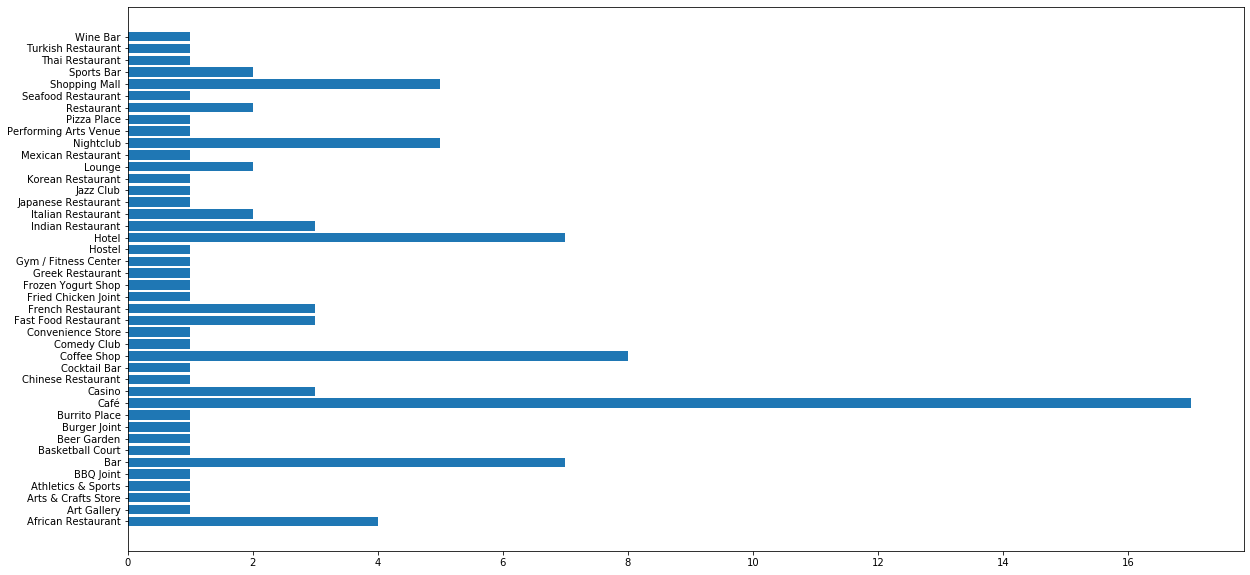

In [20]:
## counting categories
categories_count = nearby_venues.groupby('categories').count().reset_index()


plt.barh(categories_count['categories'],categories_count['name'])

### Analysing results
From the data, if we are to use <strong>categories</strong> as the classifier, our representation will be inncurate so I have clustered the information into a fre clusters

In [21]:
# give clusters to the data
def clusters(name):
    if  name == 'Restaurant': return 0
    if  name == 'Bakery': return 1
    if  name =='Café': return 2
    if  name=='Bar': return 3
    if  name =='Hotel': return 4
    if  name=='Casino': return 5
    if  name =='Club': return 6  
    if  name == 'Shop': return 7
    if  name == 'others': return 8

In [22]:
nearby_venues['clusters'] = nearby_venues.apply(lambda nearby_venues: clusters(nearby_venues['sectors']), axis=1)

In [23]:
sectors_count = nearby_venues.groupby('sectors').count().reset_index()

In [24]:
sectors_count

,sectors,name,categories,lat,lng,Neighborhood,Neighborhood latitude,Neighborhood longitude,clusters
0,Bar,11,11,11,11,11,11,11,11
1,Café,17,17,17,17,17,17,17,17
2,Casino,3,3,3,3,3,3,3,3
3,Club,8,8,8,8,8,8,8,8
4,Hotel,7,7,7,7,7,7,7,7
5,Restaurant,26,26,26,26,26,26,26,26
6,Shop,19,19,19,19,19,19,19,19
7,others,9,9,9,9,9,9,9,9


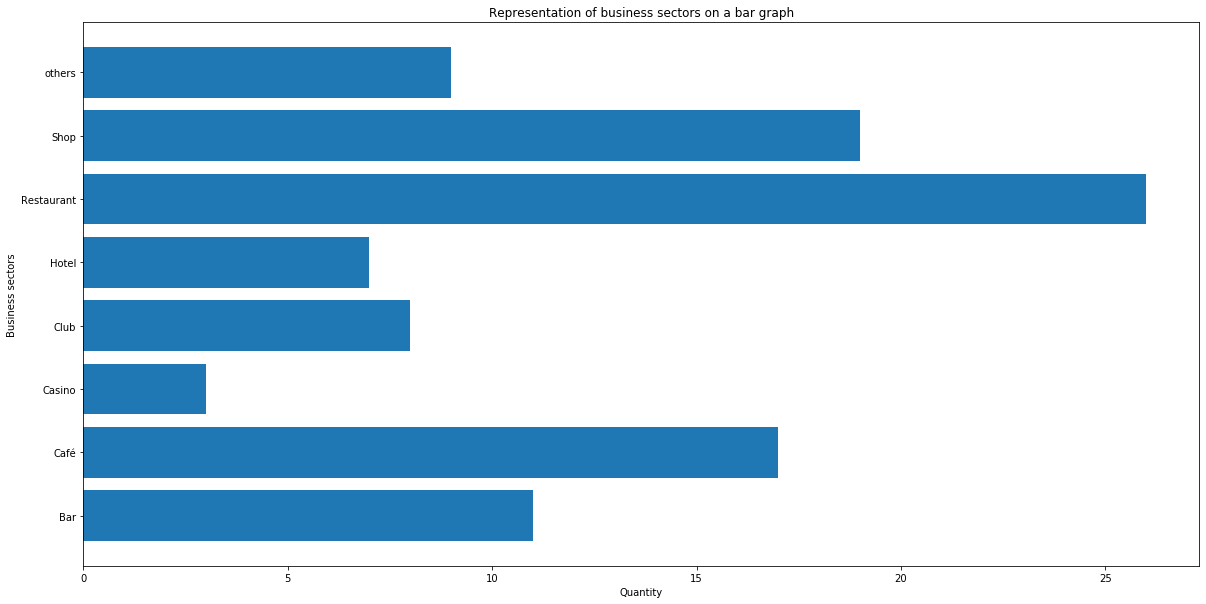

In [25]:
plt.barh(sectors_count['sectors'],sectors_count['name'])
#sns.barplot(x=sectors_count['sectors'], y=sectors_count['name'], data=sectors_count, 
#            order=sectors_count.sort_values('name').sectors)
plt.title('Representation of business sectors on a bar graph')
plt.xlabel('Quantity')
plt.ylabel('Business sectors')
plt.show()

From the graph, we see that:
    1. Restaurant are most common
    2. Shops are second
    3. Coffee shops come in third and the rest follow

Now, let us represent the data on a map

In [26]:
# create map
map_clusters = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=14)

kclusters =9

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['Neighborhood'], nearby_venues['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Findings
    1. The most common route from many people is to make clubs, with restaurants and coffee shops taking on the second and third places
     

### Further analysis of shops
    Let's try to figure our the dversity of the restaurants

In [27]:
shops_df = nearby_venues[nearby_venues['sectors']=='Restaurant']

In [28]:
shops_df.head()

,name,categories,lat,lng,Neighborhood,Neighborhood latitude,Neighborhood longitude,sectors,clusters
1,Mediterraneo Restaurant,Italian Restaurant,0.329679,32.587031,kampala,0.317714,32.581354,Restaurant,0
6,Seven 7 seas Sheraton,Seafood Restaurant,0.316527,32.583572,kampala,0.317714,32.581354,Restaurant,0
11,Tamarai Restaurant And Tea Bar,Thai Restaurant,0.326506,32.590456,kampala,0.317714,32.581354,Restaurant,0
12,Yujo Izakaya,Japanese Restaurant,0.321606,32.583695,kampala,0.317714,32.581354,Restaurant,0
17,Amagara Café Bistro,African Restaurant,0.315751,32.584462,kampala,0.317714,32.581354,Restaurant,0


In [29]:
shops_df.categories.unique()

array(['Italian Restaurant', 'Seafood Restaurant', 'Thai Restaurant',
       'Japanese Restaurant', 'African Restaurant', 'Restaurant',
       'Indian Restaurant', 'Korean Restaurant', 'French Restaurant',
       'Greek Restaurant', 'Fast Food Restaurant', 'Chinese Restaurant',
       'Mexican Restaurant', 'Pizza Place', 'Turkish Restaurant'],
      dtype=object)

In [30]:
shops_count = shops_df.groupby('categories').count().reset_index()

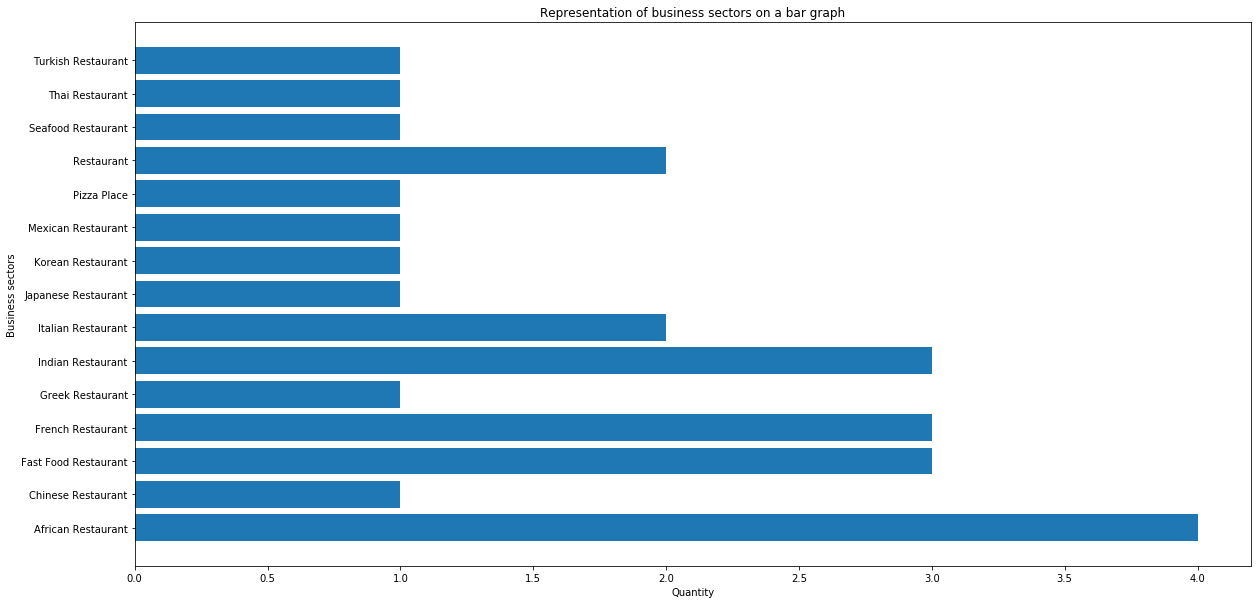

In [31]:
plt.barh(shops_count['categories'],shops_count['name'])
#sns.barplot(x=sectors_count['sectors'], y=sectors_count['name'], data=sectors_count, 
#            order=sectors_count.sort_values('name').sectors)
plt.title('Representation of business sectors on a bar graph')
plt.xlabel('Quantity')
plt.ylabel('Business sectors')
plt.show()

In [34]:
# create map
map_clusters = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=13)

kclusters =1

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(shops_df['lat'], shops_df['lng'], shops_df['Neighborhood'], shops_df['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Conclusion
From the data we see that those that specialize in a specific cuisine are the most popular. We also see that fast food restaurants are dong well too.
Some notes to take are:
1. In order for one to start a restaurant, you must have a specific cuisine to take on with the african cuisine the most preferred route.
2. Keep away from residential places like Nakasero Hill. Although these places are very high end, people avoid them proabaly because the rent is too high and there is little foot traffic.
3. Being along a main road is also the preffered route.
4. You can set up a restaurant anywhere even near you competitor but it is better to spread away from other restaurants too but not that far.